# Modelling Version 2

### Imports

In [94]:
# Standard library imports
from pathlib import Path
import os
import string
from itertools import combinations

# Third party imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report
)

In [3]:
%matplotlib inline
sns.set_style('whitegrid')
sns.set(font_scale=1.2)

### Read in data

In [4]:
data_path = Path('../data')
processed_prem_path = os.path.join(data_path, 'processed', 'processed_prem_fixtures_v2.csv')
fixtures = pd.read_csv(processed_prem_path)

In [5]:
fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7396 entries, 0 to 7395
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   match_id                            7396 non-null   int64  
 1   date                                7396 non-null   object 
 2   season                              7396 non-null   int64  
 3   team_id                             7396 non-null   int64  
 4   team_name                           7396 non-null   object 
 5   opposition_id                       7396 non-null   int64  
 6   opposition_name                     7396 non-null   object 
 7   scored                              7396 non-null   float64
 8   conceded                            7396 non-null   float64
 9   relative_score                      7396 non-null   float64
 10  league_position                     7396 non-null   int64  
 11  opposition_league_position          7396 no

## Create features

First, let's remove any fixtures where there is no head to head data available (as the teams haven't played before in the data I have collected).

In [6]:
fixtures = fixtures[fixtures['average_hth_points'].notnull()]

As many of the feautures are still reliant on gathering information from the season the fixture is played in I will remove the first 4 fixtures so the model has access to more accurate information.

In [7]:
# Get rid of early season games
fixtures = fixtures[fixtures['games_played'] > 3]
fixtures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5778 entries, 40 to 7395
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   match_id                            5778 non-null   int64  
 1   date                                5778 non-null   object 
 2   season                              5778 non-null   int64  
 3   team_id                             5778 non-null   int64  
 4   team_name                           5778 non-null   object 
 5   opposition_id                       5778 non-null   int64  
 6   opposition_name                     5778 non-null   object 
 7   scored                              5778 non-null   float64
 8   conceded                            5778 non-null   float64
 9   relative_score                      5778 non-null   float64
 10  league_position                     5778 non-null   int64  
 11  opposition_league_position          5778 n

Again, I want to calculate relative statistics between some of the features to find the difference between the teams.

In [8]:
def get_relative_statistic(fixtures, feature):
    """
    Create relative statistics columns from features about each team in
    fixture. Params:
    - fixtures: pd.DataFrame
    - feature: Statistic to calculate relative statistics from.
    """
    # Get team and opposition stats
    columns = {'team': feature, 'opposition': '_'.join(['opposition', feature])}
    
    # Reset index to avoid concat issue
    new_fixtures = fixtures.reset_index(drop=True)
    
    # Calculate relative stat
    relative_stat = fixtures[columns['team']] - fixtures[columns['opposition']]
    relative_stat = relative_stat.rename('_'.join(['relative', feature]))

    return pd.concat([fixtures, relative_stat], axis=1)

In [9]:
statistics = [
    '_'.join([prefix, stat])
    for prefix in ('HA', 'season')
    for stat in ('average_scored', 'average_points', 'form', 'average_conceded')
]
statistics.append('league_position')
for stat in statistics:
    fixtures = get_relative_statistic(fixtures, stat)

I will create interaction terms to measure the interaction for different variables between the two teams. To do this I will create a function that will return the interaction terms between team and opposition and then calculate the relative stats of these.

It doesn't make sense to calculate interaction terms from variables that can both be negative, as any occurances when both variables are negative multiplied together will make a positive. This will lose the meaning of the negative values indicating a worse result, so I won't calculate the interaction variables between statistics that can both take negative values.

In [10]:
def get_interaction_terms(fixtures, features):
    """
    Returns interaction terms between team and opposition statistics and returns the
    relative of the interaction terms.
    """
    # Label each feature alphabetically
    labeled_features = {string.ascii_uppercase[i]: feature for i, feature in enumerate(features)}
    
    interaction_terms = pd.DataFrame()
    
    # Loop through combinations of features
    for a, b in combinations(labeled_features.keys(), 2):
        # Some stats are the same for team and opposition, this determines the columns
        # needed for team and opposition
        feat_a = [labeled_features[a], '_'.join(['opposition', labeled_features[a]])]
        feat_a = feat_a if feat_a[1] in fixtures.columns else [feat_a[0]]*2
        
        feat_b = [labeled_features[b], '_'.join(['opposition', labeled_features[b]])]
        feat_b = feat_b if feat_b[1] in fixtures.columns else [feat_b[0]]*2
        
        if any(fixtures[feat_a[0]] < 0) and any(fixtures[feat_b[0]] < 0):
            continue
        
        # feat1 * opposition feat2
        stat1 = fixtures[feat_a[0]] * fixtures[feat_b[1]]
        
        # feat2 * opposition feat1
        stat2 = fixtures[feat_a[1]] * fixtures[feat_b[0]]
        
        # get relative of iteraction terms if stats calculated are different
        stat = stat1 if all(stat1 == stat2) else stat1 - stat2
        stat = stat.rename(f'{a}{b}')
        
        # Concat to all interaction terms
        interaction_terms = pd.concat([interaction_terms, stat], axis=1)
    
    # Reset index to avoid concat issues
    interaction_terms = interaction_terms.reset_index(drop=True)
    
    return pd.concat([fixtures.reset_index(drop=True), interaction_terms], axis=1)

In [11]:
interaction_features = [
    'league_position', 'HA_average_scored', 'HA_average_conceded', 'HA_average_points',
    'season_average_scored', 'season_average_conceded', 'season_average_points',
    'average_hth_points', 'average_hth_relative_score',
    'HA_form', 'season_form',
]
fixtures = get_interaction_terms(fixtures, interaction_features)

In [19]:
non_informative_cols = [
    'match_id',
    'date',
    'season',
    'team_id',
    'team_name',
    'opposition_id',
    'opposition_name',
    'scored',
    'conceded',
    'win'
]
fixture_features = ['average_hth_points', 'average_hth_relative_score']
team_features = [feat for feat in interaction_features if feat not in fixture_features]
team_features += ['_'.join(['opposition', feat]) for feat in team_features]

Now we can look at the correlation with relative score with our new interaction variables.

In [46]:
cols_to_drop = non_informative_cols + team_features + fixture_features
relative_score_corr = fixtures.drop(cols_to_drop, axis=1).corr()['relative_score'].abs()
relative_score_corr[relative_score_corr > 0.2].sort_values(ascending=False)[1:]

AB                                  0.414225
CE                                  0.409555
BF                                  0.407405
EF                                  0.404316
AD                                  0.403773
AE                                  0.403741
relative_season_average_scored      0.400154
relative_season_average_points      0.399421
AG                                  0.392420
BC                                  0.391758
relative_HA_average_points          0.386124
CG                                  0.385335
relative_HA_average_scored          0.385074
DF                                  0.382687
relative_league_position            0.380187
EH                                  0.375639
GH                                  0.375033
FG                                  0.374237
DH                                  0.365644
BH                                  0.363635
AH                                  0.361073
CD                                  0.355976
AF        

It looks like some of the interaction variables will be useful predictors, although it is likely some of the variables will be highly correlated. Before I do any modelling I will remove highly correlated variables.

## EDA

Now the target is the 'win' column, so first I will look at the variance of the target.

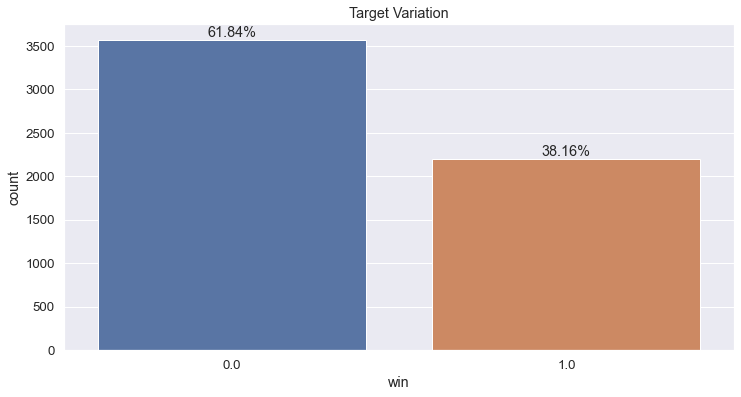

In [25]:
plt.figure(figsize=(12,6))
ax = sns.countplot(fixtures['win'])
no_fixtures = len(fixtures)
plt.title('Target Variation')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_height()
    ax.annotate(f'{100*y/no_fixtures:.2f}%', (x.mean(), y), ha='center', va='bottom')

As each fixture is repeated twice, the difference can be accounted for by the number of draws. 

Let's look at how the 'home' indicator effects the distribution of wins.

Text(64.5, 0.5, 'Home')

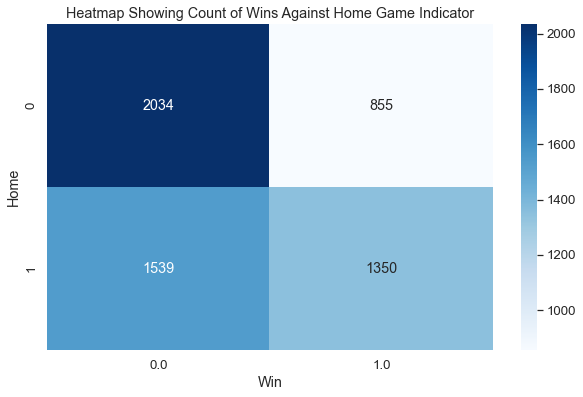

In [26]:
home_win_count = fixtures.pivot_table(index='home', columns='win', values='team_id', aggfunc='count')
plt.figure(figsize=(10, 6))
plt.title('Heatmap Showing Count of Wins Against Home Game Indicator')
sns.heatmap(home_win_count, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Win')
plt.ylabel('Home')

The heatmap shows that winning is more likley when playing at home and losing/drawing is more likley when playing away, therefore this will be a useful feature for prediction.

Now let's look if any of the features help to distinguish which team wins, again we will use the relative columns.

In [38]:
relative_cols = [
    'relative_HA_average_scored',
    'relative_season_average_scored',
    'relative_HA_average_conceded',
    'relative_season_average_conceded',
    'relative_HA_average_points',
    'relative_season_average_points',
    'relative_HA_form',
    'relative_season_form',
    'average_hth_points',
    'average_hth_relative_score',
    'relative_league_position',
]
target_col = 'win'

Now we can visualise any difference in distribution of the features based on the target.

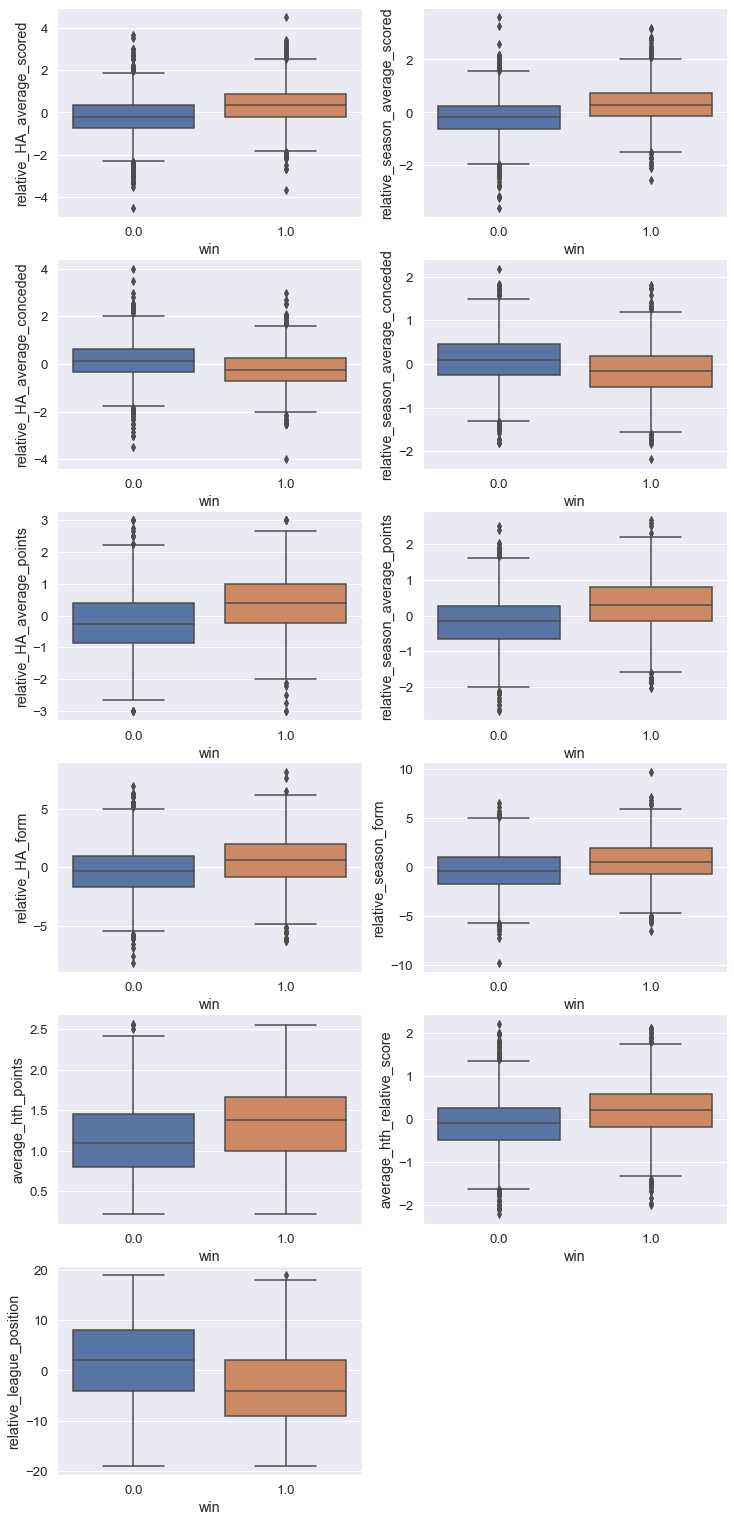

In [43]:
fig, axes = plt.subplots(
    int(np.ceil(len(relative_cols)/2)), 2, 
    figsize=(12, 5*len(relative_cols)//2))

# Remove last axes if odd features
if len(relative_cols)%2 != 0:
    fig.delaxes(axes[len(relative_cols)//2, 1])

# Plot axes
for ax, feature in enumerate(relative_cols):
    sns.boxplot(x=fixtures['win'], y=fixtures[feature], orient='v', ax=axes[ax//2, ax%2])

## Predict relative score

Let's once again try predicting the relative score, so that the degree of a win can be included in the model. First, I will seperate a subset of the features I want to use for modelling. The easiest way to do this will be to remove non informative columns and features that were soley useful for creating new features.

In [79]:
non_feature_cols = [
    'match_id', 'date', 'season', 'team_id', 'team_name', 'opposition_id',
    'opposition_name', 'scored', 'conceded', 'league_position', 
    'opposition_league_position',
#     'HA_average_scored', 'opposition_HA_average_scored', 'HA_average_conceded',
#     'opposition_HA_average_conceded', 'HA_average_points',
#     'opposition_HA_average_points', 'HA_form', 'opposition_HA_form',
#     'season_average_scored', 'opposition_season_average_scored',
#     'season_average_conceded', 'opposition_season_average_conceded',
#     'season_average_points', 'opposition_season_average_points',
#     'season_form', 'opposition_season_form',
    'games_played', 'win'
]
features_subset = fixtures.drop(non_feature_cols, axis=1)

Now we can remove features that have a low correlation with relative score.

In [81]:
realtive_score_corr = features_subset.corr()['relative_score'].abs()
features = relative_score_corr[relative_score_corr > 0.1].sort_values(ascending=False).index
features_subset = features_subset[features]

Now we want to remove features that have a high correlation. I will do this using a function that finds features that have a correlation over a threshold and then removes the feature with the lowest correlation.

In [82]:
def drop_correlated_features(dataframe, target, threshold):
    """
    Recursively finds the most highly correlated features over the correlation threshold and then 
    removes the feature with the least correlation with the target variable.
    """
    # Compute feature correlations
    features = dataframe.drop(target, axis=1)
    features_corr = features.corr().abs()
    
    # Take the upper triangle of feature correlations
    features_corr = features_corr.mask(np.tril(np.ones(features_corr.shape, dtype=np.bool_)))
    
    # Find index of correlations greater than the threshold
    correlated_features = zip(*np.where(features_corr > threshold))
    
    # Create dict, correlated features tuple : correlation
    correlated_features = {
        (features_corr.columns[i], features_corr.columns[j]): features_corr.iloc[i,j]
        for i,j in correlated_features
    }
    
    # If no correlations above threshold, return the dataframe
    if not correlated_features:
        return dataframe
    
    # Find most highly correlated features
    max_corr_features = max(correlated_features, key=correlated_features.get)
    
    # Find correlation of features with target
    target_corr = dataframe.corr().abs()[target]
    corrs_with_price = {feature: target_corr[feature] for feature in max_corr_features}
    
    # Drop feature with the least correlation with target
    feature_to_drop = min(corrs_with_price, key=corrs_with_price.get)
    new_dataframe = dataframe.drop(feature_to_drop, axis=1)
    
    return drop_correlated_features(new_dataframe, target, threshold)

I will set the threshold at 0.9 and see how the prediction performs.

In [83]:
features_subset = drop_correlated_features(features_subset, 'relative_score', 0.9)

In [84]:
X = features_subset.drop('relative_score', axis=1)
y = features_subset['relative_score']

Now I can scale the non binary features features.

In [85]:
scaler = StandardScaler()
binary_cols = ['home']
scaled_X = scaler.fit_transform(X.drop(binary_cols, axis=1))
binary_features = np.reshape(X[binary_cols].values, (-1, len(binary_cols)))
scaled_X = np.concatenate([scaled_X, binary_features], axis=1)

### Train Models

First, we split our data into a training and test set.

In [86]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=42)

In [104]:
# Train linear regression
lin_reg = LinearRegression()
MSEs = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mean_MSE = np.mean(np.sqrt(abs(MSEs)))
print('RMSE: ', mean_MSE)

RMSE:  1.6471337830197563


In [101]:
# Train lasso
lasso = Lasso(max_iter=100000)
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
lasso_reg = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_reg.fit(X_train, y_train)
print(lasso_reg.best_params_)
print('RMSE: ', np.sqrt(abs(lasso_reg.best_score_)))

{'alpha': 0.01}
RMSE:  1.64714435573024


In [99]:
# Train ridge
ridge = Ridge(max_iter=100000)
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 40, 60, 80]}
ridge_reg = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_reg.fit(X_train, y_train)
print(ridge_reg.best_params_)
print('RMSE: ', np.sqrt(abs(ridge_reg.best_score_)))

{'alpha': 20}
RMSE:  1.647877711625382


## Win classifier